# Imports

In [2]:
import cudf as pd
import numpy as np
import pandas
import shap
import seaborn as sns
import numpy
import cupy
import tensorflow
import os
import random

from cuml import train_test_split
from cuml import SVR
from cuml import RandomForestRegressor as CuRF
from keras import Sequential
from keras.src.layers import Input, LSTM, Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

from dask_cuda import LocalCUDACluster
from dask.distributed import Client

SEED = 100


def reset_seed():
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(SEED)
    numpy.random.seed(SEED)
    cupy.random.seed(SEED)
    tensorflow.random.set_seed(SEED)


cluster = LocalCUDACluster(dashboard_address=':3790')
client = Client(cluster)
reset_seed()


2024-06-11 22:58:35.836798: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/eduardoalba0/.conda/envs/rapids-24.06/lib/python3.11/site-packages/dask_cuda/utils.py:170: UserWarning: Cannot get CPU affinity for device with index 0, setting default affinity
  warnings.warn(


# Load Datasets

In [3]:
df_water = pd.read_csv('./dataset/water.csv', sep=";", decimal=".", header=0)
df_electricity = pd.read_csv('./dataset/electricity.csv', sep=";", decimal=".", header=0)
df_climatic = pd.read_csv('./dataset/climatic.csv', sep=";", decimal=".", header=0)

df_water["data"] = pd.to_datetime(df_water["data"], format="%d/%m/%Y")
df_electricity["data"] = pd.to_datetime(df_electricity["data"], format="%d/%m/%Y")
df_climatic["data"] = pd.to_datetime(df_climatic["data"], format="%d/%m/%Y")

df_water.set_index("data", inplace=True)
df_electricity.set_index("data", inplace=True)
df_climatic.set_index("data", inplace=True)



# Pré-Processamento
## Dados climáticos faltantes

In [4]:
for index, row in df_climatic[df_climatic.isnull()].to_pandas().iterrows():
    df_mes = df_climatic[df_climatic["mes"] == df_climatic.at[index, "mes"]]
    for col in row.index:
        if pandas.isnull(df_climatic.at[index, col]):
            df_mes.at[index, col] = df_mes[col].sum() / df_mes[col][df_mes[col].isnull() == False].count()
            df_climatic.at[index, col] = df_mes.at[index, col]

## Obtenção dos LAGS

In [5]:
for lag_col in ["consumo"]:
    for i in range(1, 12 + 1):
        lag_eletricity = df_electricity[lag_col].shift(i)
        df_electricity[f'{lag_col}_LAG_' + '{:02d}'.format(i)] = lag_eletricity

        lag_water = df_water[lag_col].shift(i)
        df_water[f'{lag_col}_LAG_' + '{:02d}'.format(i)] = lag_water

## União dos dados climáticos aos dados de consumo

In [6]:
df_water = pd.merge(left=df_water, right=df_climatic, on=["data", "mes", "ano"], how="left")
df_water = df_water.drop("leitura", axis=1)

df_electricity = pd.merge(left=df_electricity, right=df_climatic, on=["data", "mes", "ano"], how="left")
df_electricity = df_electricity.drop("leitura", axis=1)


## Criação das variáveis Dummy (mês e ano)

In [7]:
df_meses = pd.get_dummies(df_electricity["mes"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"1": "mes_JAN", "2": "mes_FEV", "3": "mes_MAR", "4": "mes_ABR", "5": "mes_MAI", "6": "mes_JUN",
             "7": "mes_JUL", "8": "mes_AGO", "9": "mes_SET", "10": "mes_OUT", "11": "mes_NOV", "12": "mes_DEZ"}
)
df_anos = pd.get_dummies(df_electricity["ano"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"2017": "ano_2017", "2018": "ano_2018", "2019": "ano_2019", "2020": "ano_2020", "2021": "ano_2021",
             "2022": "ano_2022", "2023": "ano_2023", "2024": "ano_2024"}
)
df_electricity = pd.concat([df_electricity, df_meses, df_anos], axis=1)
df_electricity = df_electricity.drop(["mes", "ano"], axis=1)
df_electricity = df_electricity.astype("float32").dropna()

df_meses = pd.get_dummies(df_water["mes"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"1": "mes_JAN", "2": "mes_FEV", "3": "mes_MAR", "4": "mes_ABR", "5": "mes_MAI", "6": "mes_JUN",
             "7": "mes_JUL", "8": "mes_AGO", "9": "mes_SET", "10": "mes_OUT", "11": "mes_NOV", "12": "mes_DEZ"}
)
df_anos = pd.get_dummies(df_water["ano"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"2017": "ano_2017", "2018": "ano_2018", "2019": "ano_2019", "2020": "ano_2020", "2021": "ano_2021",
             "2022": "ano_2022", "2023": "ano_2023", "2024": "ano_2024"}
)
df_water = pd.concat([df_water, df_meses, df_anos], axis=1)
df_water = df_water.drop(["mes", "ano"], axis=1)
df_water = df_water.astype("float32").dropna()

df_show = df_electricity.to_pandas()
df_show

,consumo,consumo_LAG_01,consumo_LAG_02,consumo_LAG_03,consumo_LAG_04,consumo_LAG_05,consumo_LAG_06,consumo_LAG_07,consumo_LAG_08,consumo_LAG_09,...,mes_NOV,mes_DEZ,ano_2017,ano_2018,ano_2019,ano_2020,ano_2021,ano_2022,ano_2023,ano_2024
data,,,,,,,,,,,,,,,,,,,,,
2018-09-01,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,18671.0,14487.0,10280.0,18585.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-01,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,18671.0,14487.0,10280.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-01,19998.0,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,18671.0,14487.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-01,20426.0,19998.0,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,18671.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01,10732.0,20426.0,19998.0,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,12207.0,11286.0,11897.0,21955.0,21165.0,16655.0,16964.0,14480.0,15342.0,13555.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2023-12-01,9588.0,12207.0,11286.0,11897.0,21955.0,21165.0,16655.0,16964.0,14480.0,15342.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-01-01,8226.0,9588.0,12207.0,11286.0,11897.0,21955.0,21165.0,16655.0,16964.0,14480.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Análise de Correlações
## Eletricidade
### Correlação com os LAGS

<Axes: >

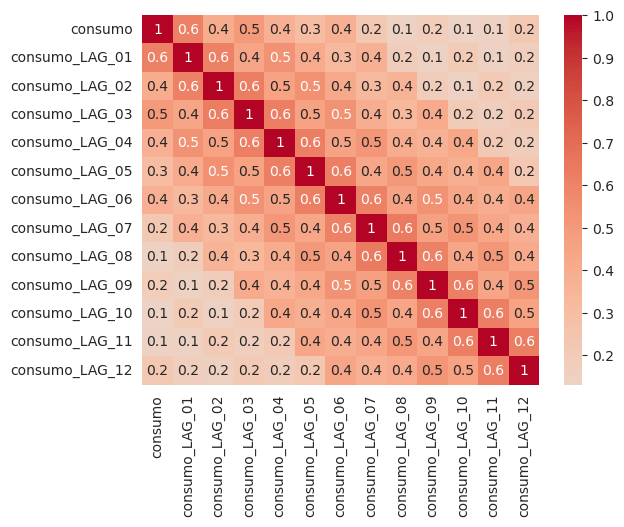

In [8]:
corr_matrix = df_electricity[df_electricity.to_pandas().filter(like="consumo").columns].dropna().to_pandas().corr(
    numeric_only=True)
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.0g')

### Correlação com as variáveis climáticas

<Axes: >

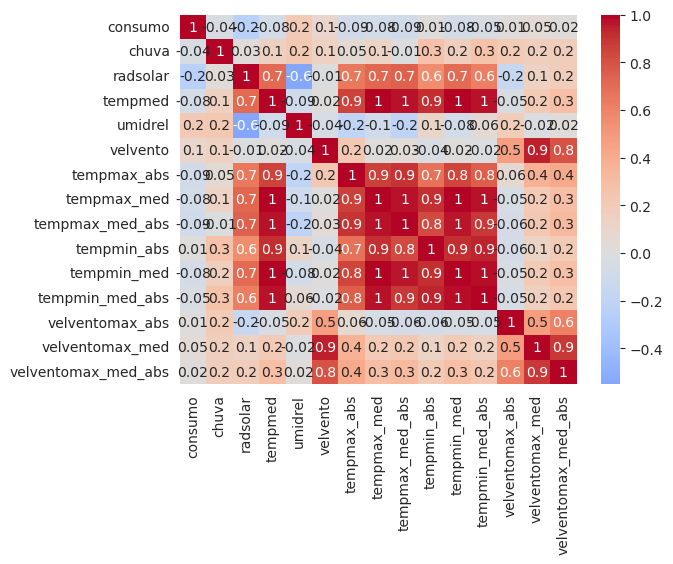

In [9]:
corr_matrix = df_electricity.drop(df_electricity.to_pandas().filter(like="_LAG_").columns,
                                  axis=1).drop(df_electricity.to_pandas().filter(like="mes_").columns,
                                               axis=1).drop(df_electricity.to_pandas().filter(like="ano_").columns,
                                                            axis=1).dropna().to_pandas().corr(numeric_only=True)
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g')

## Água
### Correlação com os LAGS

<Axes: >

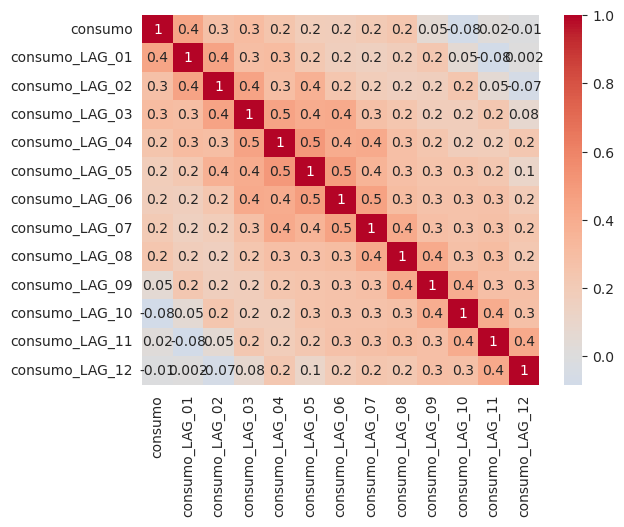

In [10]:
corr_matrix = df_water[df_water.to_pandas().filter(like="consumo").columns].dropna().to_pandas().corr(numeric_only=True)
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.0g')

### Correlação com as variáveis climáticas

<Axes: >

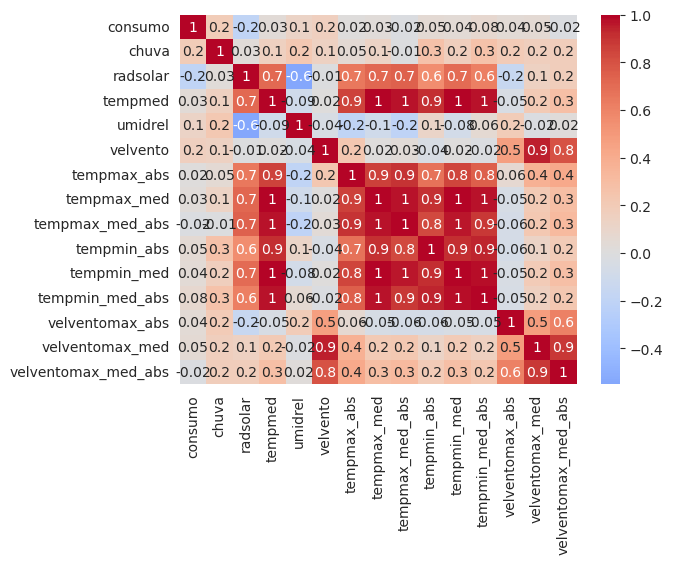

In [11]:
corr_matrix = df_water.drop(df_water.to_pandas().filter(like="_LAG_").columns,
                            axis=1).drop(df_water.to_pandas().filter(like="mes_").columns,
                                         axis=1).drop(df_water.to_pandas().filter(like="ano_").columns,
                                                      axis=1).dropna().to_pandas().corr(numeric_only=True)
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g')

## Correlação entre o Consumo de Eletricidade e de Água


<Axes: >

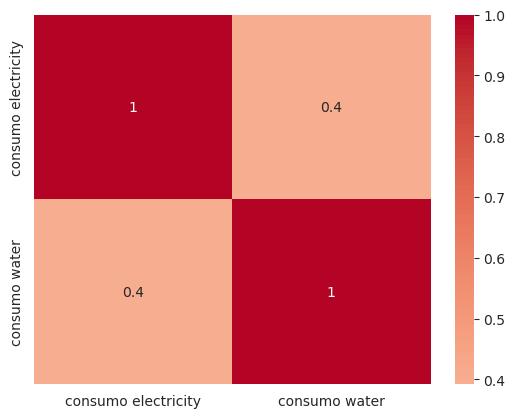

In [12]:
corr_matrix = pd.merge(left=df_electricity["consumo"], right=df_water["consumo"],
                       on=["data"], how="inner",
                       suffixes=[' electricity', ' water']).dropna().to_pandas().corr(numeric_only=True)
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g')


# Análise dos SHAP Values
## Eletricidade
### Random Forest

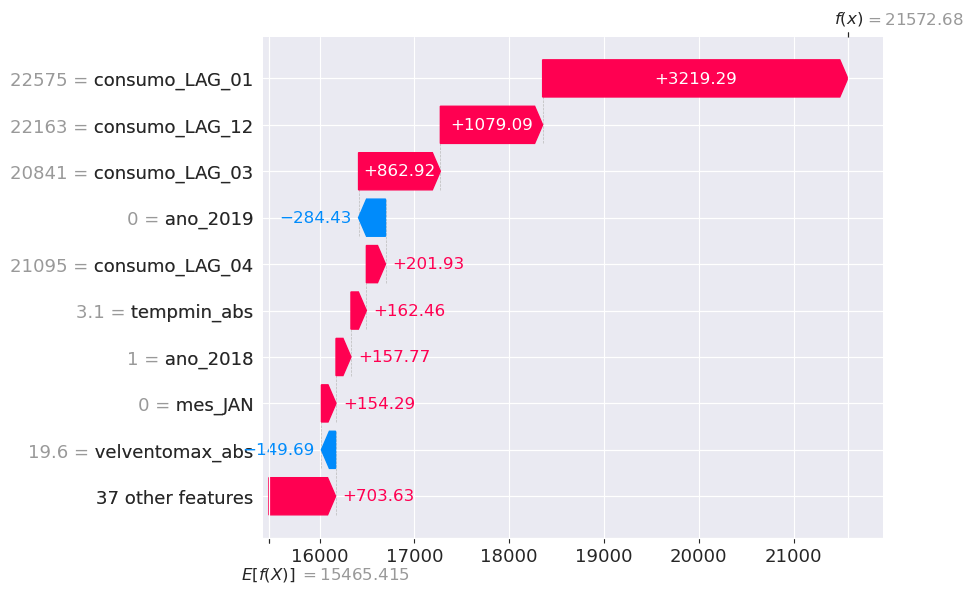

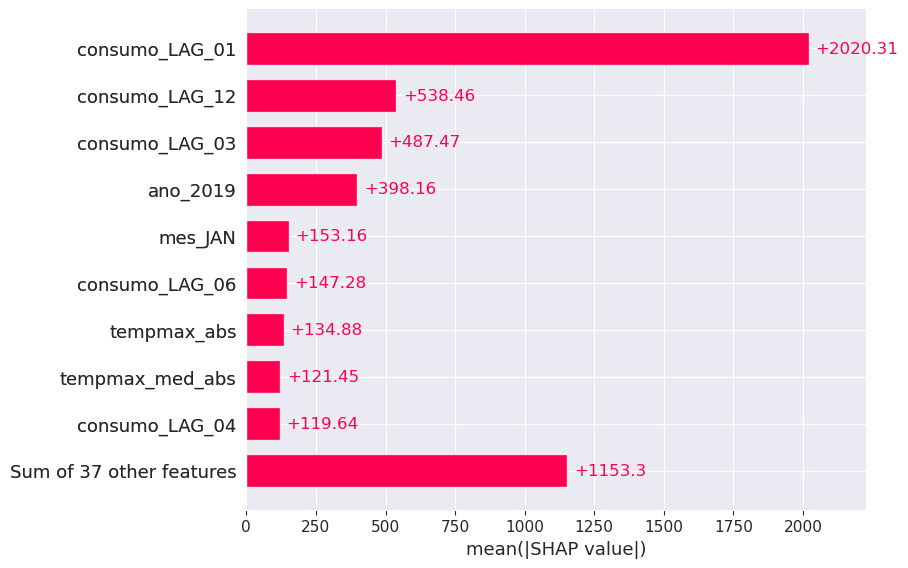

In [13]:
df_electricity_copy = df_electricity.dropna().copy().to_pandas()

x_electricity = df_electricity_copy.drop("consumo", axis=1)
y_electricity = df_electricity_copy["consumo"]
model_rf = RandomForestRegressor()
shap.initjs()

model_rf.fit(x_electricity, y_electricity)

explainer_rf = shap.Explainer(model_rf)
shap_rf = explainer_rf(x_electricity)

shap.plots.waterfall(shap_rf[0], max_display=10)
shap.plots.force(shap_rf[0])
shap.plots.bar(shap_rf)


### XGBoost

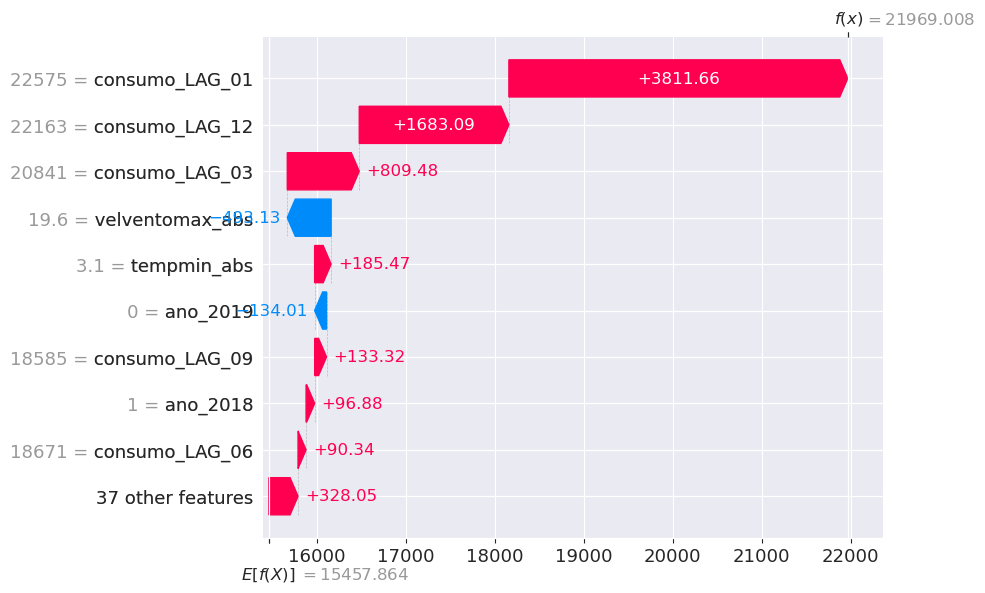

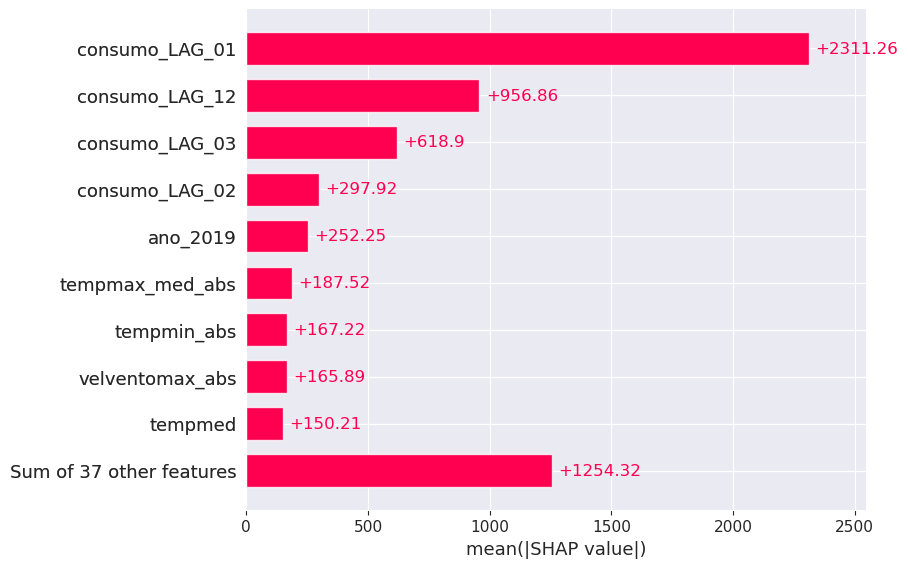

In [14]:
df_electricity_copy = df_electricity.dropna().copy().to_pandas()

x_electricity = df_electricity_copy.drop("consumo", axis=1)
y_electricity = df_electricity_copy["consumo"]

model_xgb = XGBRegressor(objective='reg:squarederror')
shap.initjs()

model_xgb.fit(x_electricity, y_electricity)

explainer_xgb = shap.Explainer(model_xgb)
shap_xgb = explainer_xgb(x_electricity)

shap.plots.waterfall(shap_xgb[0], max_display=10)
shap.plots.force(shap_xgb[0])
shap.plots.bar(shap_xgb)

## Água
### Random Forest

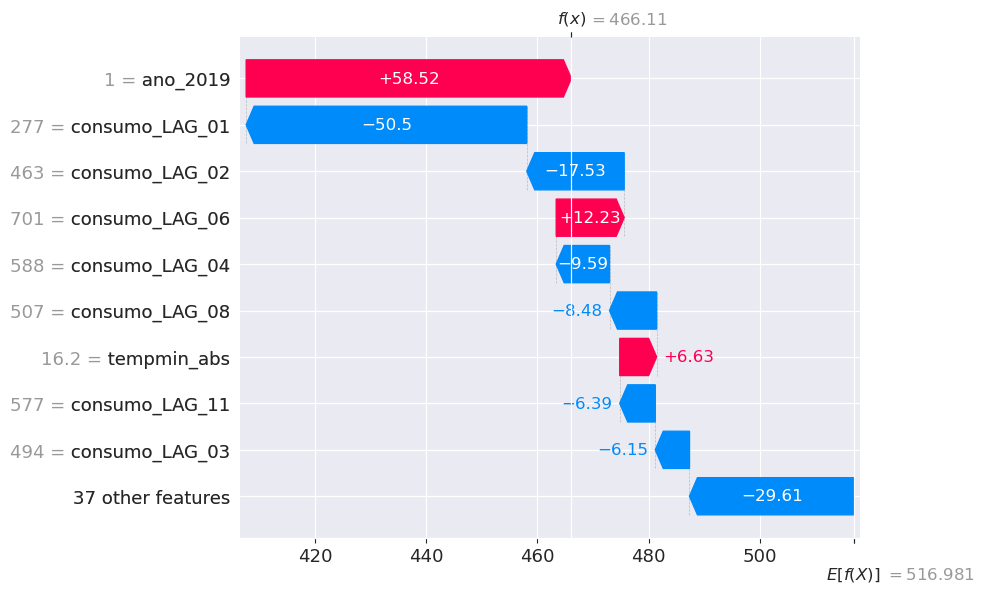

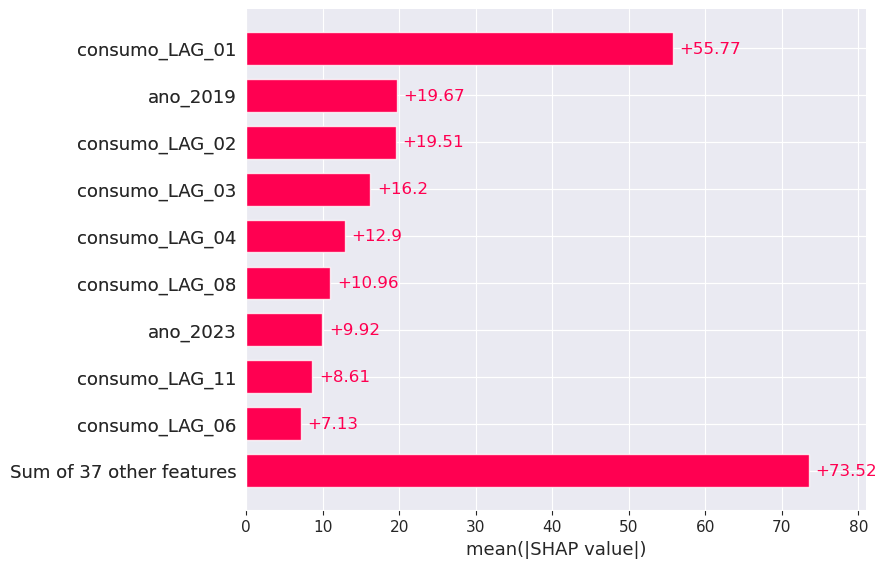

In [15]:
df_water_copy = df_water.dropna().copy().to_pandas()

x_water = df_water_copy.drop("consumo", axis=1)
y_water = df_water_copy["consumo"]
model_rf = RandomForestRegressor()
shap.initjs()

model_rf.fit(x_water, y_water)

explainer_rf = shap.Explainer(model_rf)
shap_rf = explainer_rf(x_water)

shap.plots.waterfall(shap_rf[0], max_display=10)
shap.plots.force(shap_rf[0])
shap.plots.bar(shap_rf)


### XGBoost

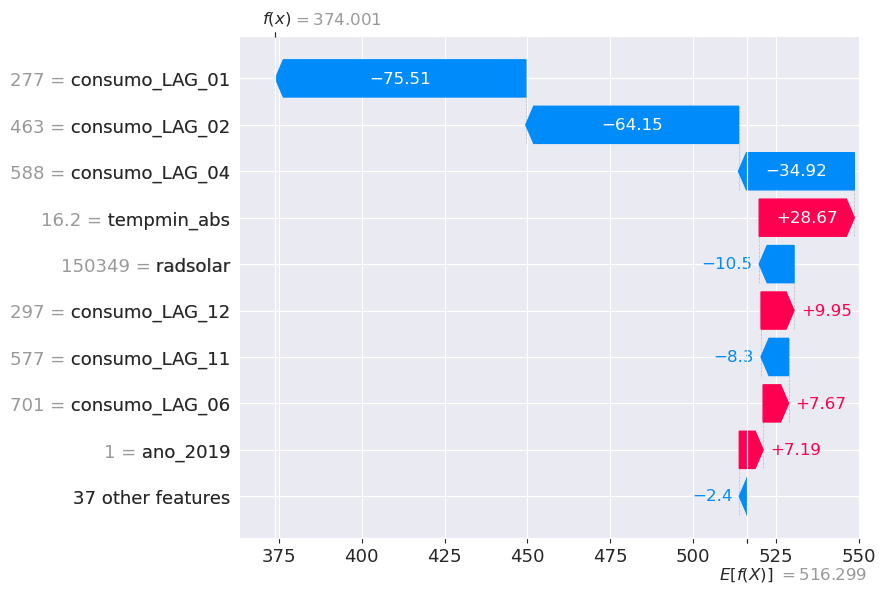

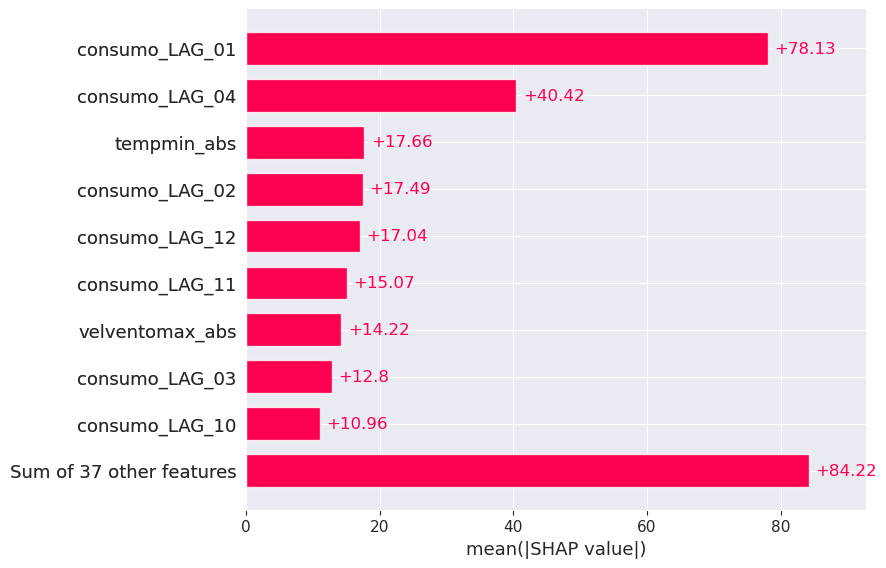

In [16]:
df_water_copy = df_water.dropna().copy().to_pandas()

x_water = df_water_copy.drop("consumo", axis=1)
y_water = df_water_copy["consumo"]

model_xgb = XGBRegressor(objective='reg:squarederror')
shap.initjs()

model_xgb.fit(x_water, y_water)

explainer_xgb = shap.Explainer(model_xgb)
shap_xgb = explainer_xgb(x_water)

shap.plots.waterfall(shap_xgb[0], max_display=10)
shap.plots.force(shap_xgb[0])
shap.plots.bar(shap_xgb)

# Configuração dos Otimizadores
## Algoritmo Genético
### Indivíduos

### Operações

In [17]:
class GA:
    def __init__(self, dataset, n_individuos, n_populacao, crossover, mutacao):
        self.dataset = dataset
        self.n_individuos = n_individuos
        self.n_populacao = n_populacao
        self.crossover = crossover
        self.mutacao = mutacao
        self.populacao = []

## Enxame de Partículas

# Aplicação dos Otimizadores
## Random Forest
### Eletricidade

### Água

## XGBoost
### Eletricidade

### Água

## SVR
### Eletricidade

### Água

## LSTM
### Eletricidade

### Água

## XGBoost
### Eletricidade

### Água

# Previsões
## Eletricidade
### 3 Passos à frente

In [70]:
reset_seed()
x_electricity = df_electricity.drop("consumo", axis=1)
y_electricity = df_electricity["consumo"]

xgb_electricity = XGBRegressor()
rf_electricity = CuRF(n_streams=1, n_bins=x_electricity.shape[1])
svr_electricity = SVR()
lstm_electricity = Sequential([
    Input((x_electricity.shape[1], 1), batch_size=x_electricity.shape[1]),
    LSTM(30, activation='relu', seed=SEED),
    Dense(1),
])
lstm_electricity.compile(loss='mse', metrics=['mean_absolute_error'])

x_train, x_test, y_train, y_test = train_test_split(x_electricity, y_electricity, test_size=3, shuffle=False)

cvs_electricity = pd.DataFrame()
for i_train, i_test in TimeSeriesSplit(n_splits=12, test_size=1).split(x_train, y_train):
    kx_train, kx_test = x_train.iloc[i_train].to_numpy(), x_train.iloc[i_test].to_numpy()
    ky_train, ky_test = y_train.iloc[i_train].to_numpy(), y_train.iloc[i_test].to_numpy()

    xgb_electricity.fit(kx_train, ky_train)
    rf_electricity.fit(kx_train, ky_train)
    svr_electricity.fit(kx_train, ky_train)
    lstm_electricity.fit(kx_train, ky_train, shuffle=False, verbose=False, epochs=1, batch_size=x_electricity.shape[1])
    cvs_electricity = pd.concat([cvs_electricity, pd.DataFrame({
        "XGB": mean_absolute_percentage_error(xgb_electricity.predict(kx_test), ky_test),
        "RF": mean_absolute_percentage_error(rf_electricity.predict(kx_test), ky_test),
        "SVR": mean_absolute_percentage_error(svr_electricity.predict(kx_test), ky_test),
        "LSTM": mean_absolute_percentage_error(lstm_electricity.predict(kx_test), ky_test)
    })])

pred_xgb_electricity = []
for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]]

    for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
        sx_test.at[sx_test.index, climatic_column] = x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
    for lag in range(i_test + 1):
        if lag == 0:
            continue
        sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_xgb_electricity[-lag]

    pred_xgb_electricity.append(xgb_electricity.predict(sx_test.to_numpy())[0])

pred_rf_electricity = []
for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]]

    for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
        sx_test.at[sx_test.index, climatic_column] = x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
    for lag in range(i_test + 1):
        if lag == 0:
            continue
        sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_rf_electricity[-lag]

    pred_rf_electricity.append(rf_electricity.predict(sx_test.to_numpy())[0])

pred_svr_electricity = []
for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]]

    for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
        sx_test.at[sx_test.index, climatic_column] = x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
    for lag in range(i_test + 1):
        if lag == 0:
            continue
        sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_svr_electricity[-lag]

    pred_svr_electricity.append(svr_electricity.predict(sx_test.to_numpy())[0])
    
pred_lstm_electricity = []
for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]]

    for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
        sx_test.at[sx_test.index, climatic_column] = x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
    for lag in range(i_test + 1):
        if lag == 0:
            continue
        sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_lstm_electricity[-lag]

    pred_lstm_electricity.append(lstm_electricity.predict(sx_test.to_numpy())[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


ValueError: Column must have no nulls.

### 6 Passos à frente

In [85]:
reset_seed()
x_electricity = df_electricity.drop("consumo", axis=1)
y_electricity = df_electricity["consumo"]

xgb_electricity = XGBRegressor()
rf_electricity = CuRF(n_streams=1, n_bins=x_electricity.shape[1])
svr_electricity = SVR()
lstm_electricity = Sequential([
    Input((x_electricity.shape[1], 1), batch_size=x_electricity.shape[1]),
    LSTM(30, activation='relu', seed=SEED),
    Dense(1),
])
lstm_electricity.compile(loss='mse', metrics=['mean_absolute_error'])

x_train, x_test, y_train, y_test = train_test_split(x_electricity, y_electricity, test_size=6, shuffle=False)

cvs_electricity = pd.DataFrame()
for i_train, i_test in TimeSeriesSplit(n_splits=12, test_size=1).split(x_train, y_train):
    kx_train, kx_test = x_train.iloc[i_train].to_numpy(), x_train.iloc[i_test].to_numpy()
    ky_train, ky_test = y_train.iloc[i_train].to_numpy(), y_train.iloc[i_test].to_numpy()

    xgb_electricity.fit(kx_train, ky_train)
    rf_electricity.fit(kx_train, ky_train)
    svr_electricity.fit(kx_train, ky_train)
    lstm_electricity.fit(kx_train, ky_train, shuffle=False, verbose=False, epochs=1, batch_size=x_electricity.shape[1])
    cvs_electricity = pd.concat([cvs_electricity, pd.DataFrame({
        "XGB": mean_absolute_percentage_error(xgb_electricity.predict(kx_test), ky_test),
        "RF": mean_absolute_percentage_error(rf_electricity.predict(kx_test), ky_test),
        "SVR": mean_absolute_percentage_error(svr_electricity.predict(kx_test), ky_test),
        "LSTM": mean_absolute_percentage_error(lstm_electricity.predict(kx_test), ky_test)
    })])

pred_xgb_electricity = []
for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]]

    for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
        sx_test.at[sx_test.index, climatic_column] = x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
    for lag in range(i_test + 1):
        if lag == 0:
            continue
        sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_xgb_electricity[-lag]

    pred_xgb_electricity.append(xgb_electricity.predict(sx_test.to_numpy())[0])

pred_rf_electricity = []
for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]]

    for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
        sx_test.at[sx_test.index, climatic_column] = x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
    for lag in range(i_test + 1):
        if lag == 0:
            continue
        sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_rf_electricity[-lag]

    pred_rf_electricity.append(rf_electricity.predict(sx_test.to_numpy())[0])

pred_svr_electricity = []
for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]]

    for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
        sx_test.at[sx_test.index, climatic_column] = x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
    for lag in range(i_test + 1):
        if lag == 0:
            continue
        sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_svr_electricity[-lag]

    pred_svr_electricity.append(svr_electricity.predict(sx_test.to_numpy())[0])
    
pred_lstm_electricity = []
for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]]

    for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
        sx_test.at[sx_test.index, climatic_column] = x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
    for lag in range(i_test + 1):
        if lag == 0:
            continue
        sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_lstm_electricity[-lag]

    pred_lstm_electricity.append(lstm_electricity.predict(sx_test.to_numpy())[0])


### 12 Passos à frente

In [94]:
reset_seed()
x_electricity = df_electricity.drop("consumo", axis=1)
y_electricity = df_electricity["consumo"]

xgb_electricity = XGBRegressor()
rf_electricity = CuRF(n_streams=1, n_bins=x_electricity.shape[1])
svr_electricity = SVR()
lstm_electricity = Sequential([
    Input((x_electricity.shape[1], 1), batch_size=x_electricity.shape[1]),
    LSTM(30, activation='relu', seed=SEED),
    Dense(1),
])
lstm_electricity.compile(loss='mse', metrics=['mean_absolute_error'])

x_train, x_test, y_train, y_test = train_test_split(x_electricity, y_electricity, test_size=12, shuffle=False)

cvs_electricity = pd.DataFrame()
for i_train, i_test in TimeSeriesSplit(n_splits=12, test_size=1).split(x_train, y_train):
    kx_train, kx_test = x_train.iloc[i_train].to_numpy(), x_train.iloc[i_test].to_numpy()
    ky_train, ky_test = y_train.iloc[i_train].to_numpy(), y_train.iloc[i_test].to_numpy()

    xgb_electricity.fit(kx_train, ky_train)
    rf_electricity.fit(kx_train, ky_train)
    svr_electricity.fit(kx_train, ky_train)
    lstm_electricity.fit(kx_train, ky_train, shuffle=False, verbose=False, epochs=1, batch_size=x_electricity.shape[1])
    cvs_electricity = pd.concat([cvs_electricity, pd.DataFrame({
        "XGB": mean_absolute_percentage_error(xgb_electricity.predict(kx_test), ky_test),
        "RF": mean_absolute_percentage_error(rf_electricity.predict(kx_test), ky_test),
        "SVR": mean_absolute_percentage_error(svr_electricity.predict(kx_test), ky_test),
        "LSTM": mean_absolute_percentage_error(lstm_electricity.predict(kx_test), ky_test)
    })])

pred_xgb_electricity = []
for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]]

    for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
        sx_test.at[sx_test.index, climatic_column] = x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
    for lag in range(i_test + 1):
        if lag == 0:
            continue
        sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_xgb_electricity[-lag]

    pred_xgb_electricity.append(xgb_electricity.predict(sx_test.to_numpy())[0])

pred_rf_electricity = []
for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]]

    for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
        sx_test.at[sx_test.index, climatic_column] = x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
    for lag in range(i_test + 1):
        if lag == 0:
            continue
        sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_rf_electricity[-lag]

    pred_rf_electricity.append(rf_electricity.predict(sx_test.to_numpy())[0])

pred_svr_electricity = []
for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]]

    for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
        sx_test.at[sx_test.index, climatic_column] = x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
    for lag in range(i_test + 1):
        if lag == 0:
            continue
        sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_svr_electricity[-lag]

    pred_svr_electricity.append(svr_electricity.predict(sx_test.to_numpy())[0])
    
pred_lstm_electricity = []
for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]]

    for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
        sx_test.at[sx_test.index, climatic_column] = x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
    for lag in range(i_test + 1):
        if lag == 0:
            continue
        sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_lstm_electricity[-lag]

    pred_lstm_electricity.append(lstm_electricity.predict(sx_test.to_numpy())[0])


/home/eduardoalba0/.conda/envs/rapids-24.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: The number of bins, `n_bins` is greater than the number of samples used for training. Changing `n_bins` to number of training samples.
  ret = func(*args, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


## Água
### 3 Passos à frente

,consumo_LAG_01,consumo_LAG_02,consumo_LAG_03,consumo_LAG_04,consumo_LAG_05,consumo_LAG_06,consumo_LAG_07,consumo_LAG_08,consumo_LAG_09,consumo_LAG_10,...,mes_NOV,mes_DEZ,ano_2017,ano_2018,ano_2019,ano_2020,ano_2021,ano_2022,ano_2023,ano_2024
data,,,,,,,,,,,,,,,,,,,,,
2024-03-01,16390.0,8226.0,9588.0,12207.0,11286.0,11897.0,21955.0,21165.0,16655.0,16964.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 6 Passos à frente

12 Passos à frente